Gene splicing
=============

In the GMGalaxies call on 4 Nov, Corentin suggested an idea he called "anti-GM",
to keep a target region completely fixed while allowing the exterior to be
re-randomised. Thus, one could directly examine the effect of the environment
on the evolution of a particular halo/galaxy.

This notebook shows how to implement this idea.

First, note that the idea is basically like applying a Hoffman-Ribak constraint on every
single pixel within the "frozen" region. Linear genetic modifications are equivalent to
HR constraints, and thus one could in principle implement using the existing genetIC code.

However, that is not feasible in reality, because for every pixel inside the region one
would need a separate constraint vector, each of which are the size of an entire simulation box.
The storage requirements would be enormous, and the computation time would probably
be enormous too.

Reformulating as a minimisation problem
---------------------------------------

While GMs are equivalent to Hoffman-Ribak constraints, they are derived differently
(see e.g. Rey & Pontzen 2018). The goal is to minimize the difference between an
initial field and a final modified field, subject to constraints (which is _not_ the
formulation in the HR paper). From this perspective, a different solution suggests
itself, which by construction is still equivalent to imposing all the many
required HR constraints.

Call the values in the original field $\vec{a}$, and those in a completely independent
realization $\vec{b}$. Also suppose we have a mask matrix $\mathsf{M}$ which zeros the pixels
outside the "frozen" region. From the GM perspective, we want to find a new field $\vec{f}$
satisfying:

$$\begin{aligned} \textrm{minimise } Q &= (\vec{b} - \vec{f})^{\dagger} \mathsf{C}^{-1} (\vec{b} - \vec{f})\textrm{,} \\ \textrm{subject to } \mathsf{M} \vec{f} & = \mathsf{M} \vec{a} \end{aligned} $$

This is a convex minimisation problem, which should be soluble using standard approaches (e.g. conjugate gradient).

Solution of the minimisation
----------------------------

Minimising quadratic functions like $Q$ subject to equality constraints is a well-studied
problem. The key issue is that a naive minimisation of such systems can be quite unstable.
The best thing is to reformulate the problem into a constrained and unconstrained part, then
solving only the unconstrained part. Luckily this is quite easy for the current system. We
write

$$ \vec{\Delta} = \vec{f} - \vec{b}$$

and note that the constraint is now $\mathsf{M} \vec{\Delta} = \mathsf{M}(\vec{a} - \vec{b})$.
This allows us to write that, for the correct solution, one has:

$$ \vec{\Delta} = \mathsf{M}(\vec{a} - \vec{b}) + \bar{\mathsf{M}} \vec{\alpha} $$

Here $\bar{\mathsf{M}}$ is the "inverse mask", defined by
$\bar{\mathsf{M}} = \mathbb{I} - \mathsf{M}$. The free part of the solution is entirely
in $\vec{\alpha}$ and the constraint on $\vec{\Delta}$ is enforced by construction.
We can now devise an algorithm for finding the optimal solution for $\vec{\alpha}$.
Back-substituting our definitions into $Q$, we have

$$ Q = \vec{\alpha}^{\dagger} \bar{\mathsf{M}} \mathsf{C}^{-1} \bar{\mathsf{M}} \vec{\alpha} + \vec{\alpha}^{\dagger} \bar{\mathsf{M}} \mathsf{C}^{-1} \mathsf{M} (\vec{a} - \vec{b}) + \mathrm{c.c.} + \mathrm{const.}$$

Here c.c. just indicates the complex conjugate of the preceding term, while the
constant term does not depend on the thing we are now optimizing, $\vec{\alpha}$,
and therefore does not need explicit calculation. I have used the fact that all the matrices
$\mathsf{C}$, $\mathsf{M}$ and $\bar{\mathsf{M}}$ are Hermitian.

Minimising $Q$ (now without any constraints) requires

$$ \bar{\mathsf{M}} \mathsf{C}^{-1} \bar{\mathsf{M}}\vec{\alpha} = \bar{\mathsf{M}} \mathsf{C}^{-1} \mathsf{M} (\vec{b} - \vec{a}) $$

This is an equation of the form $\mathsf{X} \vec{\alpha} = \vec{z}$ and can be
solved by standard conjugate gradient optimization!

The solution is then to find $\vec{\alpha}$ in this way, back-substituting to find
$\vec{\Delta}$ and so $\vec{f}$.

Preconditioning
---------------

To get the conjugate gradient to converge in a small number of iterations, the matrix
must have as narrow a spectrum of eigenvalues as possible. Zero eigenvalues are not
a problem (in effect, the CG returns the pseudo-inverse, as though the matrix were
regularised by adding a small identity component).

Roughly speaking, other than its null space, the matrix $Q$ has a spectrum similar to 
that of $\mathsf{C}^{-1}$. Thus, we want instead to solve the following equivalent problem:

$$ \tilde{\mathsf{Q}} \tilde{\vec{\alpha}} =  \mathsf{C}^{-1/2} \vec{\Delta} $$

$$ \textrm{where } \tilde{\mathsf{Q}} = \mathsf{C}^{1/2} \mathsf{Q} \mathsf{C}^{1/2} $$

and then the solution in terms of $\vec{\alpha}$ is obtained by the 
final manipulation,  $\vec{\alpha} = \mathsf{C}^{1/2} \tilde{\vec{\alpha}} $.



Setup
-----

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as p

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# borrow simple FFT wrappers from the constrainedzoom toy implementation of
# genetIC (in the tools/toy_implementation folder)
from constrainedzoom.fft_wrapper import FFTArray



For illustration, we will need to define a power spectrum / covariance that has a reasonably short
correlation length (like in cosmology) but that is not too much like 'white noise'
that there are no long-range effects at all. I have chosen $P(k) \propto (k_0+k)^{-2}$, with
$k_0$ being sufficiently far away from the fundamental mode but not too close to the
Nyquist frequency.

In [2]:
def covariance(k):
    k0 = (1./len(k))**0.5/7
    cov = (k0+k)**-2
    #cov = np.ones_like(k)
    return cov

def inverse_covariance(k):
    inv = covariance(k)**-1
    return inv

In [3]:
def whitenoise_realization(npix=512) -> FFTArray:
    ar = FFTArray(np.random.normal(0.0,1.0,npix)) # white noise
    ar.fourier = False
    return ar

def realization(npix=512) -> FFTArray:
    """Create a realization of the random field with the chosen number of pixels"""
    ar = whitenoise_realization(npix)
    ar.in_fourier_space()
    ar*=covariance(ar.k)**0.5
    return ar.in_real_space()

Rather than use scipy's conjugate gradient, we use our own custom conjugate gradient routine to ensure it can be
exactly reproduced inside genetIC

In [4]:
from constrainedzoom.methods.detail.cg import conjugate_gradient  


In [5]:
def splice(a: FFTArray, b: FFTArray, mask: np.ndarray, 
           precondition=True, in_fourier_space=False) -> FFTArray:
    """Perform the 'splicing' operation, as described above.

    a: the field that will be retained inside the mask
    b: the new realization that f should approximate outside the mask
    mask: a boolean array describing the region where 'a' should be retained
    return_X_matrix: if True, instead of solving the problem, return the X matrix
    use_scipy: if True, use the scipy conjugate gradient solver
    precondition: if True, use preconditioner

    Returns: f, the 'spliced' field
    """

    a.in_real_space()
    b.in_real_space()

    cov = covariance(a.k)
    inv_cov = inverse_covariance(a.k)
    inv_mask = ~mask


    z = ((mask*(b-a)).in_fourier_space()*inv_cov).in_real_space()*inv_mask

    if precondition:
        z.in_fourier_space()
        z*=cov**0.5

    if in_fourier_space:
        z.in_fourier_space()
    else:
        z.in_real_space()
        
    def X(v):
            """Implementation of the X matrix for the gradient descent problem.

            Returns the value of Xv for any vector v"""
            r = v.view(FFTArray).copy()
            if in_fourier_space:
                assert v.fourier
                r.fourier = True
            else:
                assert not v.fourier
                r.fourier = False

            if precondition:
                r.in_fourier_space()
                r*=cov**0.5
            else:
                r.fourier = False

            r.in_real_space()
            r*=inv_mask

            r.in_fourier_space()
            r*=inv_cov
            r.in_real_space()
            r*=inv_mask
            if precondition:
                r.in_fourier_space()
                r*=cov**0.5

            if in_fourier_space:
                r.in_fourier_space()
            else:
                r.in_real_space()
            return r

    alpha = conjugate_gradient(X,z)

    if precondition:
        #assert alpha.fourier
        alpha.in_fourier_space()
        alpha*=cov**0.5


    alpha.in_real_space()

    # put the pieces together into a final solution!
    return mask*(a-b) + inv_mask * alpha + b


Create a demonstration setup to show the results in action

In [6]:
Npix = 2000
np.random.seed(3)
start_mask = 220
end_mask = 410

a = realization(Npix)
b = realization(Npix)
mask = np.zeros(Npix, dtype=bool)
mask[start_mask:end_mask] = True

Converged after 3 iterations


(-156.00513494576091, 156.00513494576091)

<Figure size 1800x1200 with 1 Axes>

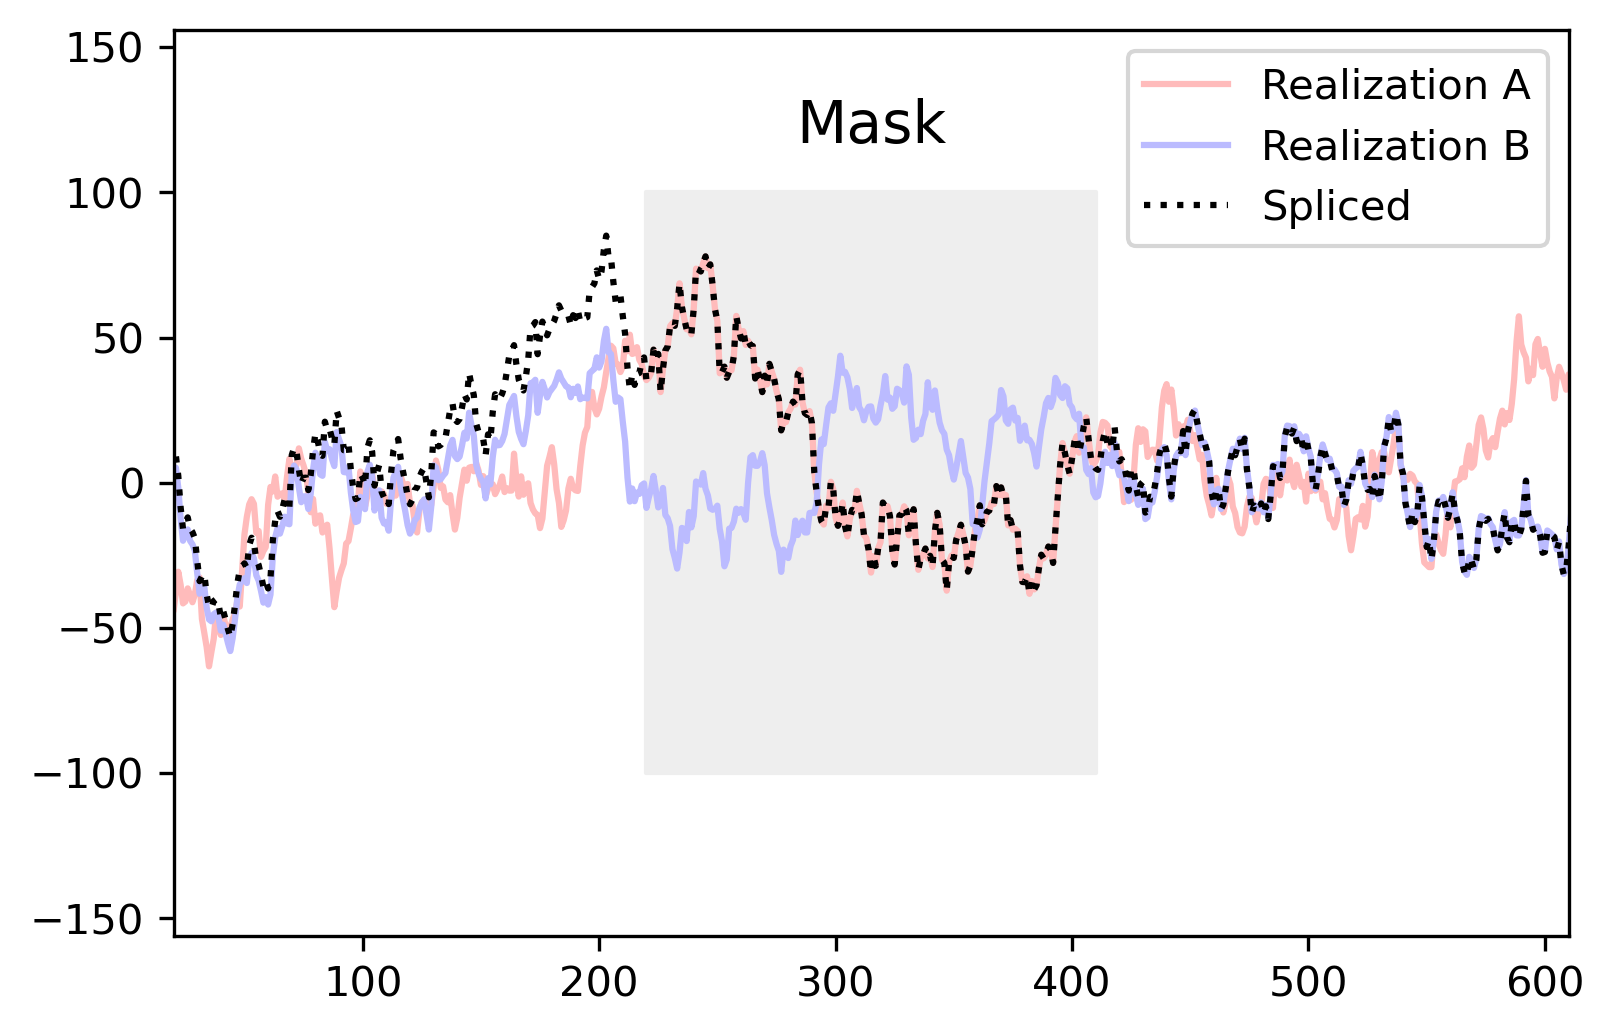

In [7]:
p.plot(a,color='#ffbbbb')
p.plot(b,color='#bbbbff')
p.plot(splice(a,b,mask),"k:")
p.legend(["Realization A","Realization B","Spliced"])
p.fill_betweenx([-100,100],start_mask,end_mask,color='#eeeeee')
p.xlim(start_mask-200,end_mask+200)
p.text((start_mask+end_mask)/2, max(a)*1.5, "Mask", horizontalalignment='center', fontsize=14)
p.ylim(-max(a)*2,max(a)*2)


Use in zoom simulations
-----------------------

Roughly, if one has a zoom simulation, the levels of the zoom simulation can be treated independently;
if the field is replaced in the same region on each level, when combined the overall field will also be
replaced in that region.

This isn't precisely true in detail because of the filtering operations, which 'smear' information a little.
In practice, the zoom region requires us to splice the high-resolution whitenoise, $\mathbf{n}_H$, and the low-resolution whitenoise $\mathbf{n}_L$ separately.
Because the final high-resolution density will be given by (see [Stopyra+2020](https://arxiv.org/abs/2006.01841), Eq. A.18)
$$
\mathbf{\delta}_H = F_{WH} C_H^{1/2}\mathbf{n}_H + m^{-1/2}P_W^+ W_P F_{PL} C_L^{1/2}\mathbf{n}_L,
$$
so that we need to splice $\mathbf{n}_H$ with covariance matrix $F_{WH}^2 C_H$ and $\mathbf{n}_L$ with covariance matrix $F_{PL}^2 C_L$, i.e. we filter out the low-$k$ modes when splicing the zoomed region, and we filter out the high-$k$ modes when splicing the coarse region.
Note that because the coarse region will then be upsampled to the high-resolution, we need to add a buffer region of size $m$, where $m$ is the resolution ratio between the high-res and the low-res.

The zoom implementation also operates directly on the noise, rather than on the convolved field. This is only a 'change of field basis' operation, and so shouldn't lead to any changes. Let's check that first by re-solving the single-level problem dealt with explicitly above.

In [8]:
import constrainedzoom as cz

In [9]:
np.random.seed(3)
noise_a = whitenoise_realization(Npix)
noise_b = whitenoise_realization(Npix)
cov = covariance(noise_a.k)
noise_s = cz.methods.ZoomConstrained._splice_realizations_one_level(noise_a, noise_b, cov, mask)

Converged after 3 iterations


In [10]:
rel_a = (noise_a.in_fourier_space()*cov**0.5).in_real_space()
rel_b = (noise_b.in_fourier_space()*cov**0.5).in_real_space()
rel_s = (noise_s.in_fourier_space()*cov**0.5).in_real_space()

(-156.00513494576091, 156.00513494576091)

<Figure size 1800x1200 with 1 Axes>

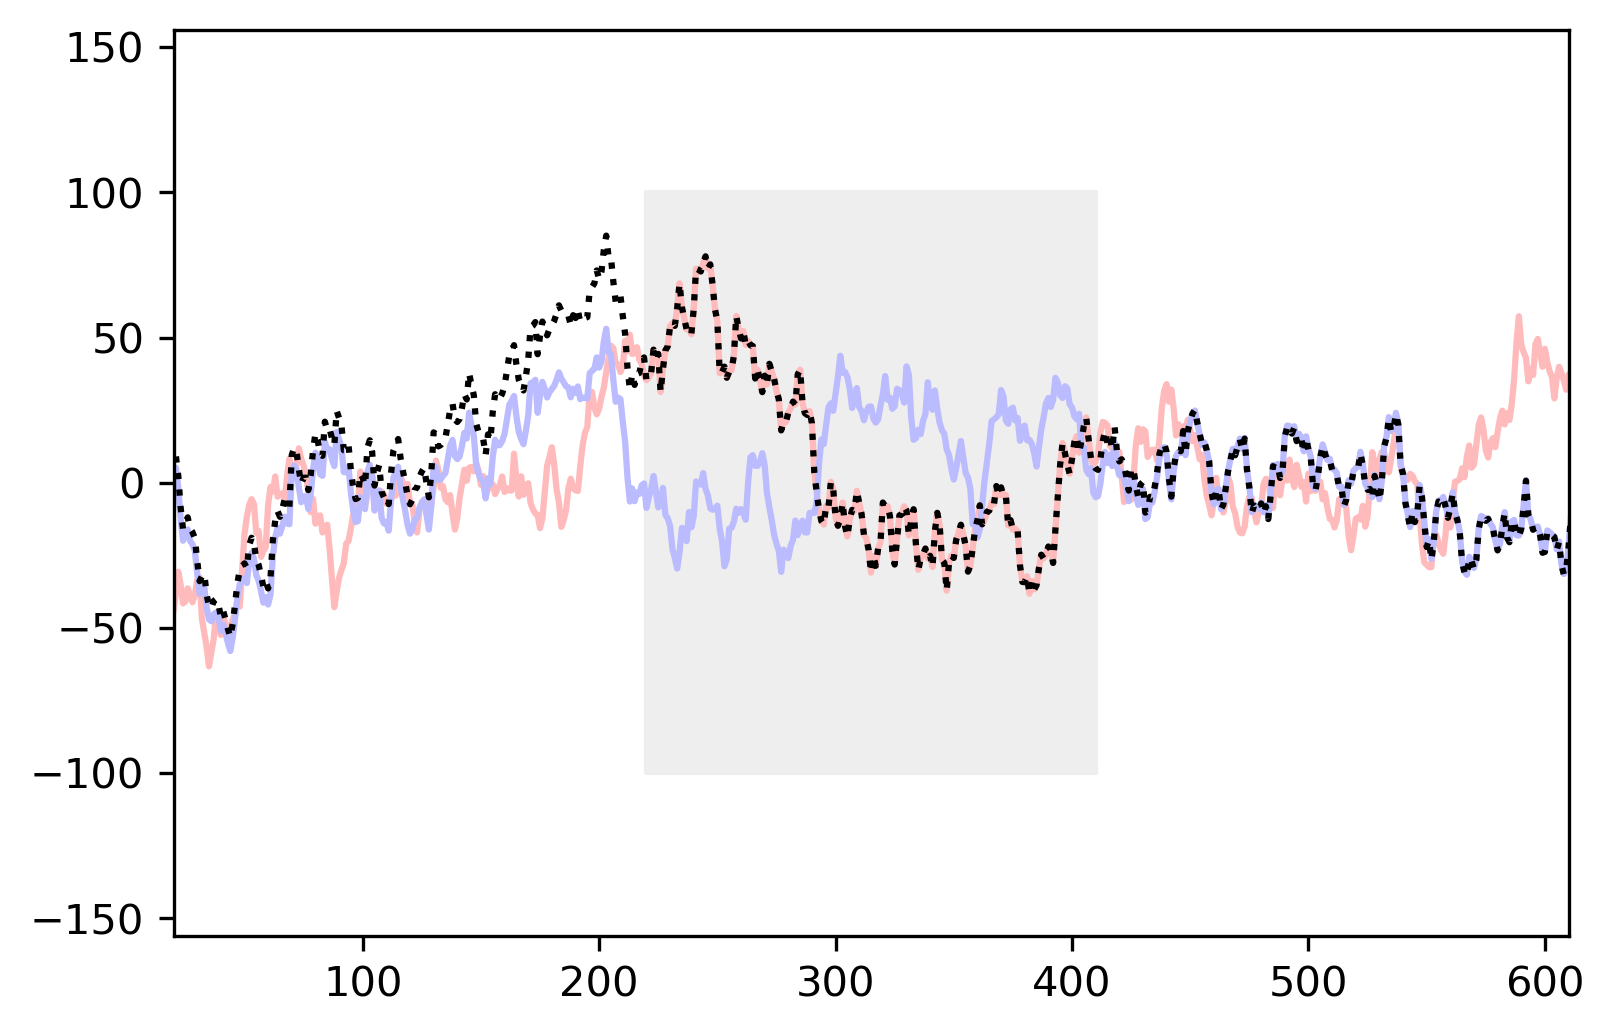

In [11]:
p.plot(rel_a,color='#ffbbbb')
p.plot(rel_b,color='#bbbbff')
p.plot(rel_s,"k:")
p.fill_betweenx([-100,100],start_mask,end_mask,color='#eeeeee')
p.xlim(start_mask-200,end_mask+200)
p.ylim(-max(rel_a)*2,max(rel_a)*2)

Everything looks good in this case of manipulating the noise field. Now let's see this in action on multiple levels. The basic problem is the same, although the covariance is different due to the architecture of the toy implementation.

Converged after 3 iterations
Converged after 6 iterations


(0.0, 0.5)

<Figure size 1800x1200 with 1 Axes>

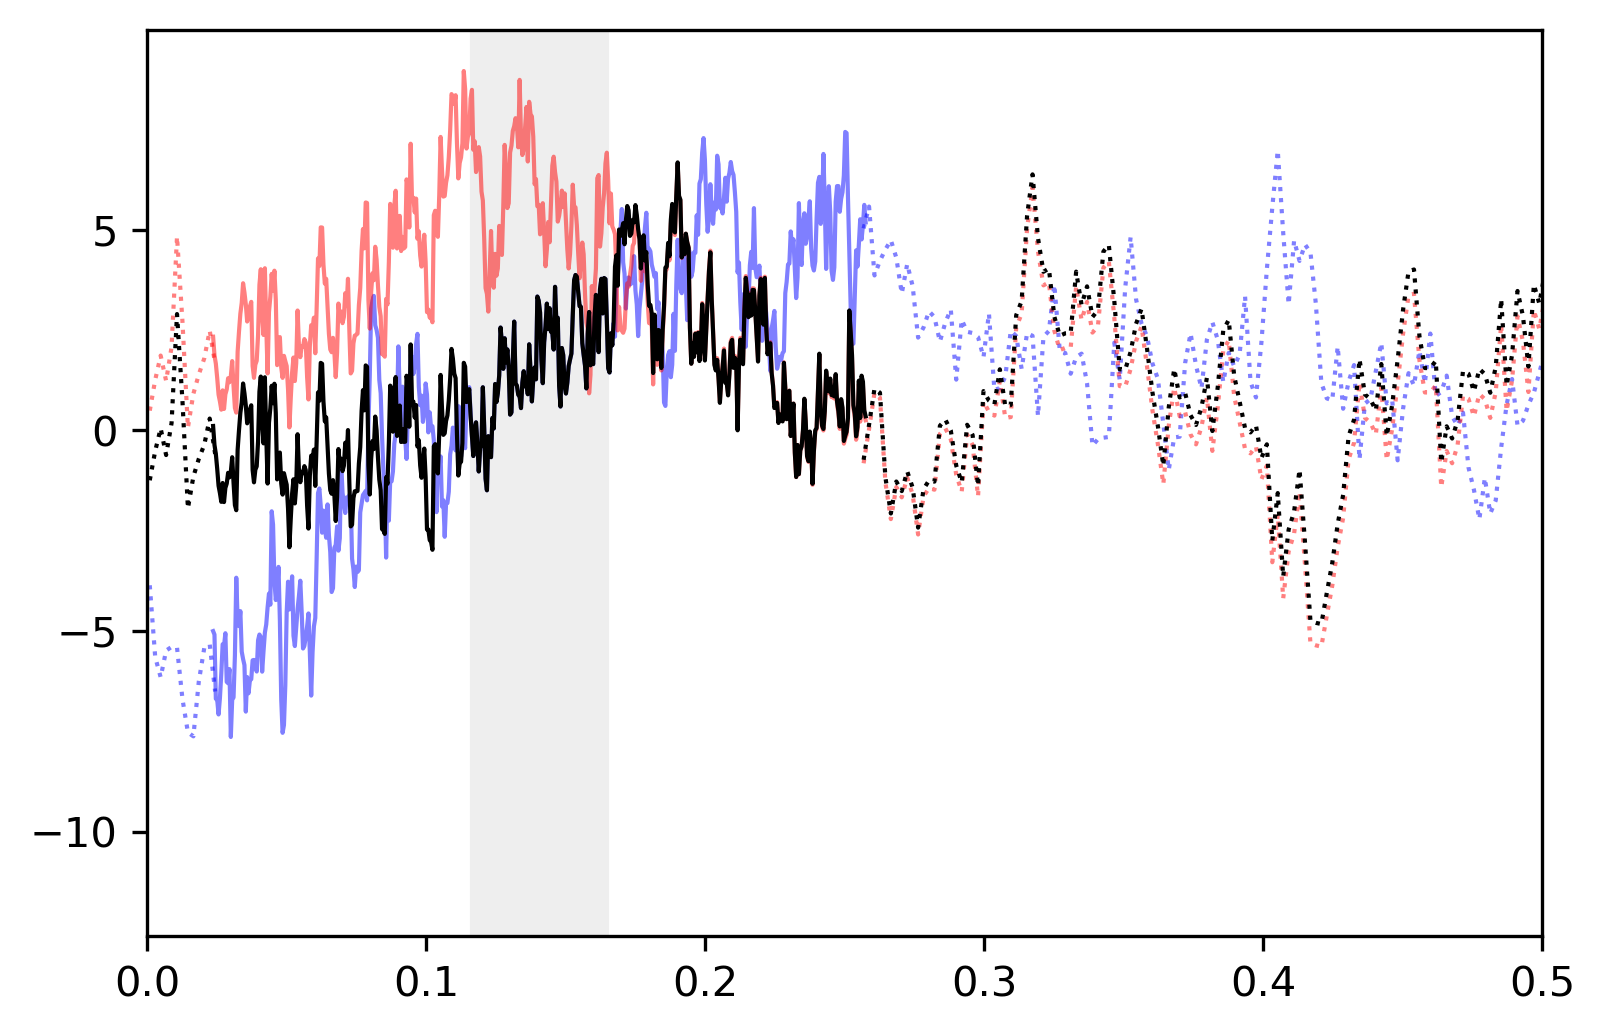

In [12]:
%autoreload 2
import constrainedzoom.plots
constrainedzoom.methods.use_filters=True
N = 512
splice_range = (256-50, 256+50)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,plaw=-1.5,plot_kwargs={'alpha':0.5, 'color':'b'}, linewidth=1)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=2,plaw=-1.5,plot_kwargs={'alpha':0.5, 'color':'r'}, linewidth=1)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,splice_range=splice_range,plaw=-1.5,plot_kwargs={'color':'k'}, linewidth=1)
p.xlim(0.00, 0.5)



Converged after 3 iterations
Converged after 6 iterations
Converged after 3 iterations
Converged after 6 iterations
Converged after 3 iterations
Converged after 6 iterations


Text(0.5, 1.0, 'Difference with inner realization')

<Figure size 3000x900 with 3 Axes>

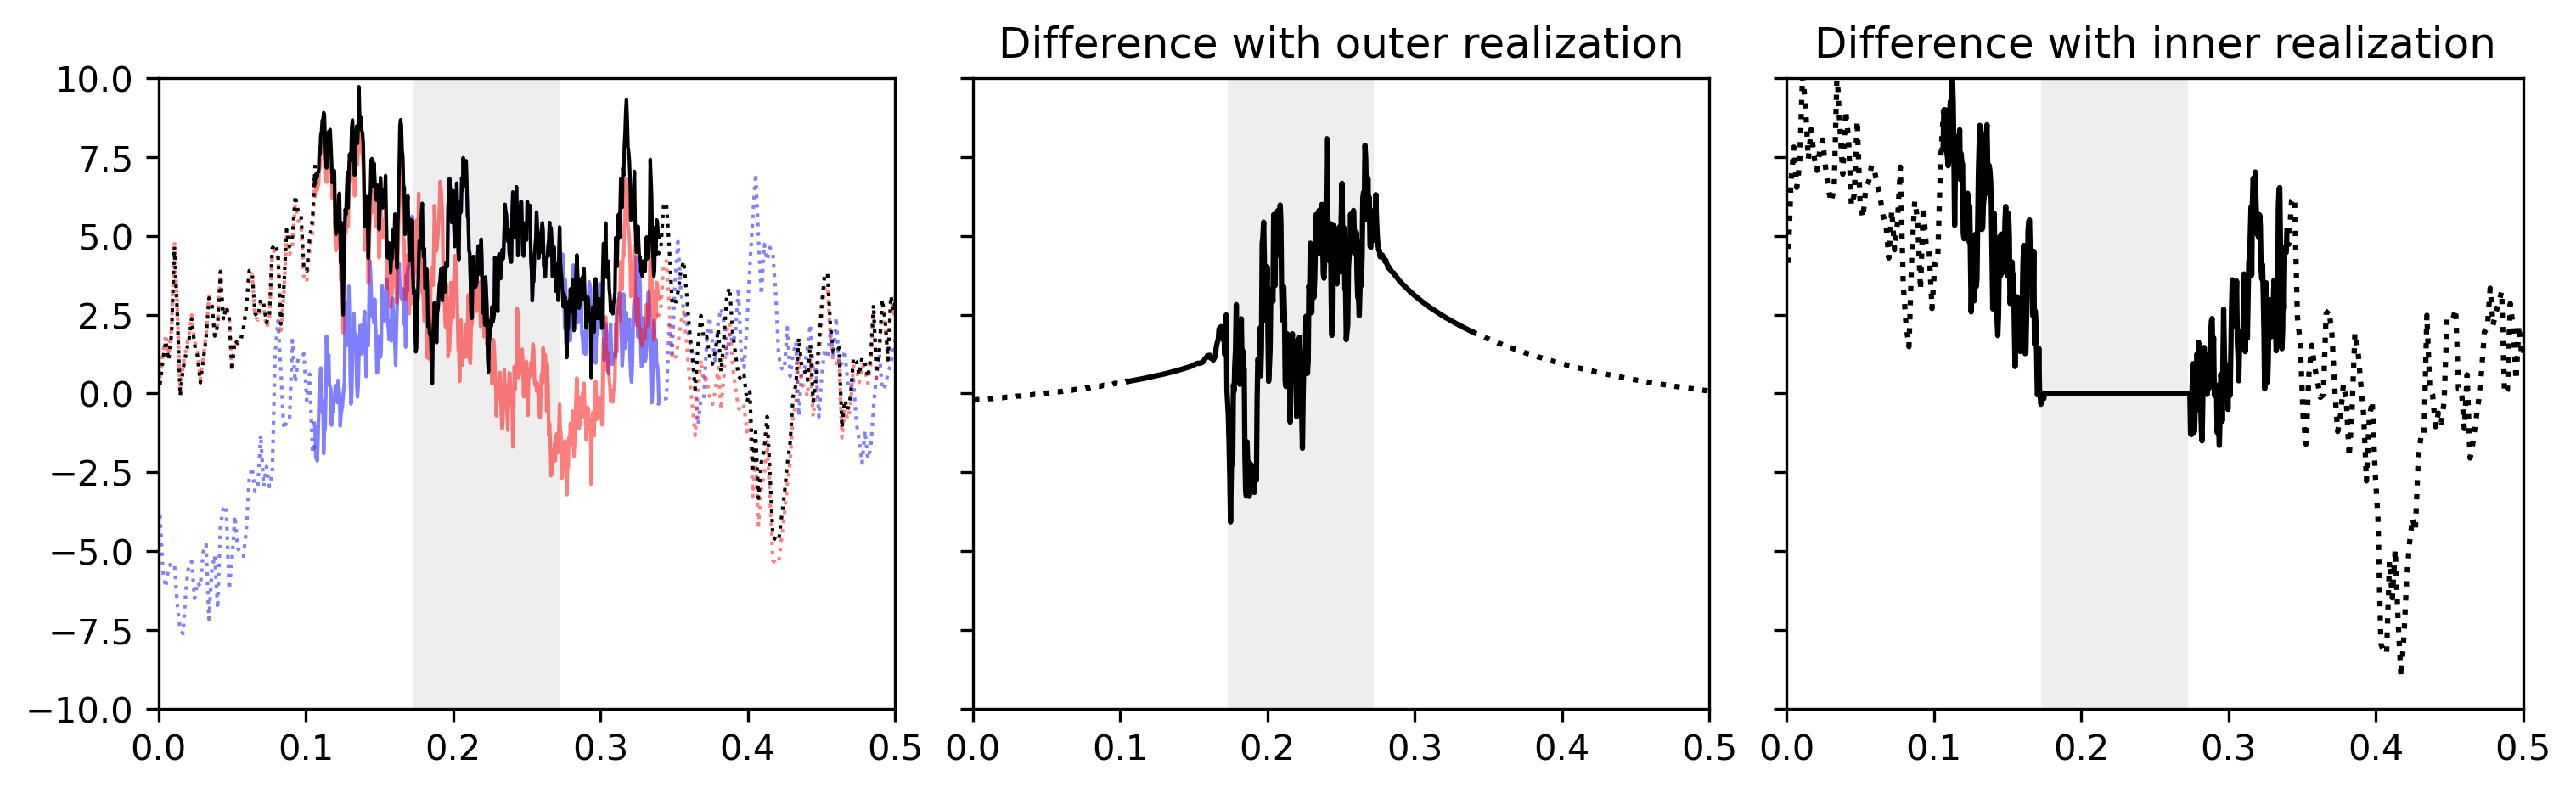

In [14]:
%autoreload 2
import constrainedzoom.plots
constrainedzoom.methods.use_filters=True
N = 512
splice_range = (256-100, 256+100)
offset = 50
fig, axes = p.subplots(ncols=3, figsize=(10, 3), sharex=True, sharey=True, constrained_layout=True)
fig.sca(axes[0])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,plaw=-1.5,plot_kwargs={'alpha':0.5, 'color':'b'}, linewidth=1, hires_window_offset=offset)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=2,plaw=-1.5,plot_kwargs={'alpha':0.5, 'color':'r'}, linewidth=1, hires_window_offset=offset)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,splice_range=splice_range,plaw=-1.5,plot_kwargs={'color':'k'}, linewidth=1, hires_window_offset=offset)
p.xlim(0.00, 0.5)

fig.sca(axes[1])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,diff_seed=2,splice_range=splice_range,plaw=-1.5,plot_kwargs={'color':'k'}, hires_window_offset=offset)
p.xlim(0.00, .5)
p.title("Difference with outer realization")

fig.sca(axes[2])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,diff_seed=1,splice_range=splice_range,plaw=-1.5, plot_kwargs={"color": "k"}, hires_window_offset=offset)
p.xlim(0.0,0.5)
p.ylim(-10,10)
p.title("Difference with inner realization")

Converged after 3 iterations
Converged after 6 iterations
Converged after 3 iterations
Converged after 6 iterations
Converged after 3 iterations
Converged after 6 iterations


Text(0.5, 1.0, 'Difference with inner realization')

<Figure size 3000x900 with 3 Axes>

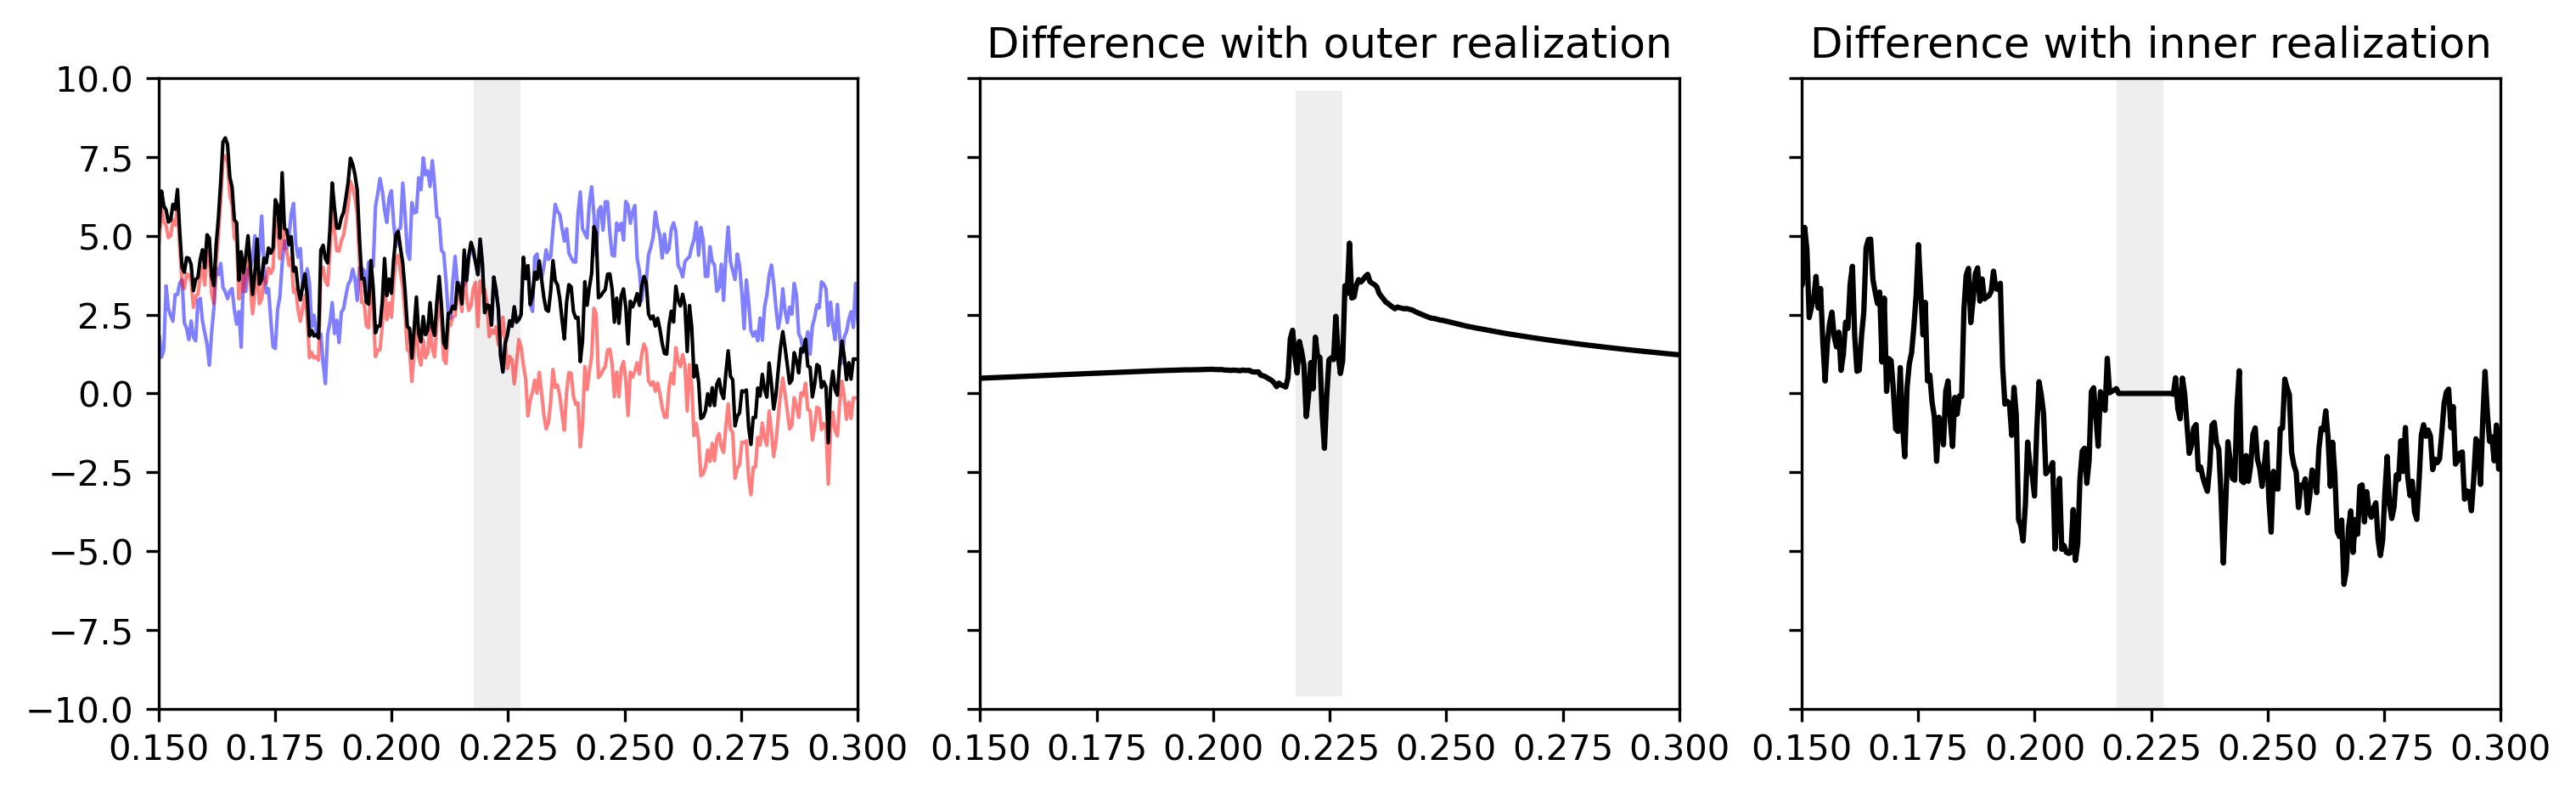

In [15]:
%autoreload 2
import constrainedzoom.plots
constrainedzoom.methods.use_filters=True
N = 512
splice_range = (256-10, 256+10)
offset = 50
fig, axes = p.subplots(ncols=3, figsize=(10, 3), sharex=True, sharey=True, constrained_layout=True)
fig.sca(axes[0])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,plaw=-1.5,plot_kwargs={'alpha':0.5, 'color':'b'}, linewidth=1, hires_window_offset=offset)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=2,plaw=-1.5,plot_kwargs={'alpha':0.5, 'color':'r'}, linewidth=1, hires_window_offset=offset)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,splice_range=splice_range,plaw=-1.5,plot_kwargs={'color':'k'}, linewidth=1, hires_window_offset=offset)

fig.sca(axes[1])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,diff_seed=2,splice_range=splice_range,plaw=-1.5,plot_kwargs={'color':'k'}, hires_window_offset=offset)
p.title("Difference with outer realization")

fig.sca(axes[2])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,diff_seed=1,splice_range=splice_range,plaw=-1.5, plot_kwargs={"color": "k"}, hires_window_offset=offset)
p.xlim(0.15, 0.3)
p.ylim(-10,10)
p.title("Difference with inner realization")

Converged after 2 iterations
Converged after 6 iterations
Converged after 2 iterations
Converged after 6 iterations
Converged after 2 iterations
Converged after 6 iterations


Text(0.5, 1.0, 'Difference with inner realization')

<Figure size 3000x900 with 3 Axes>

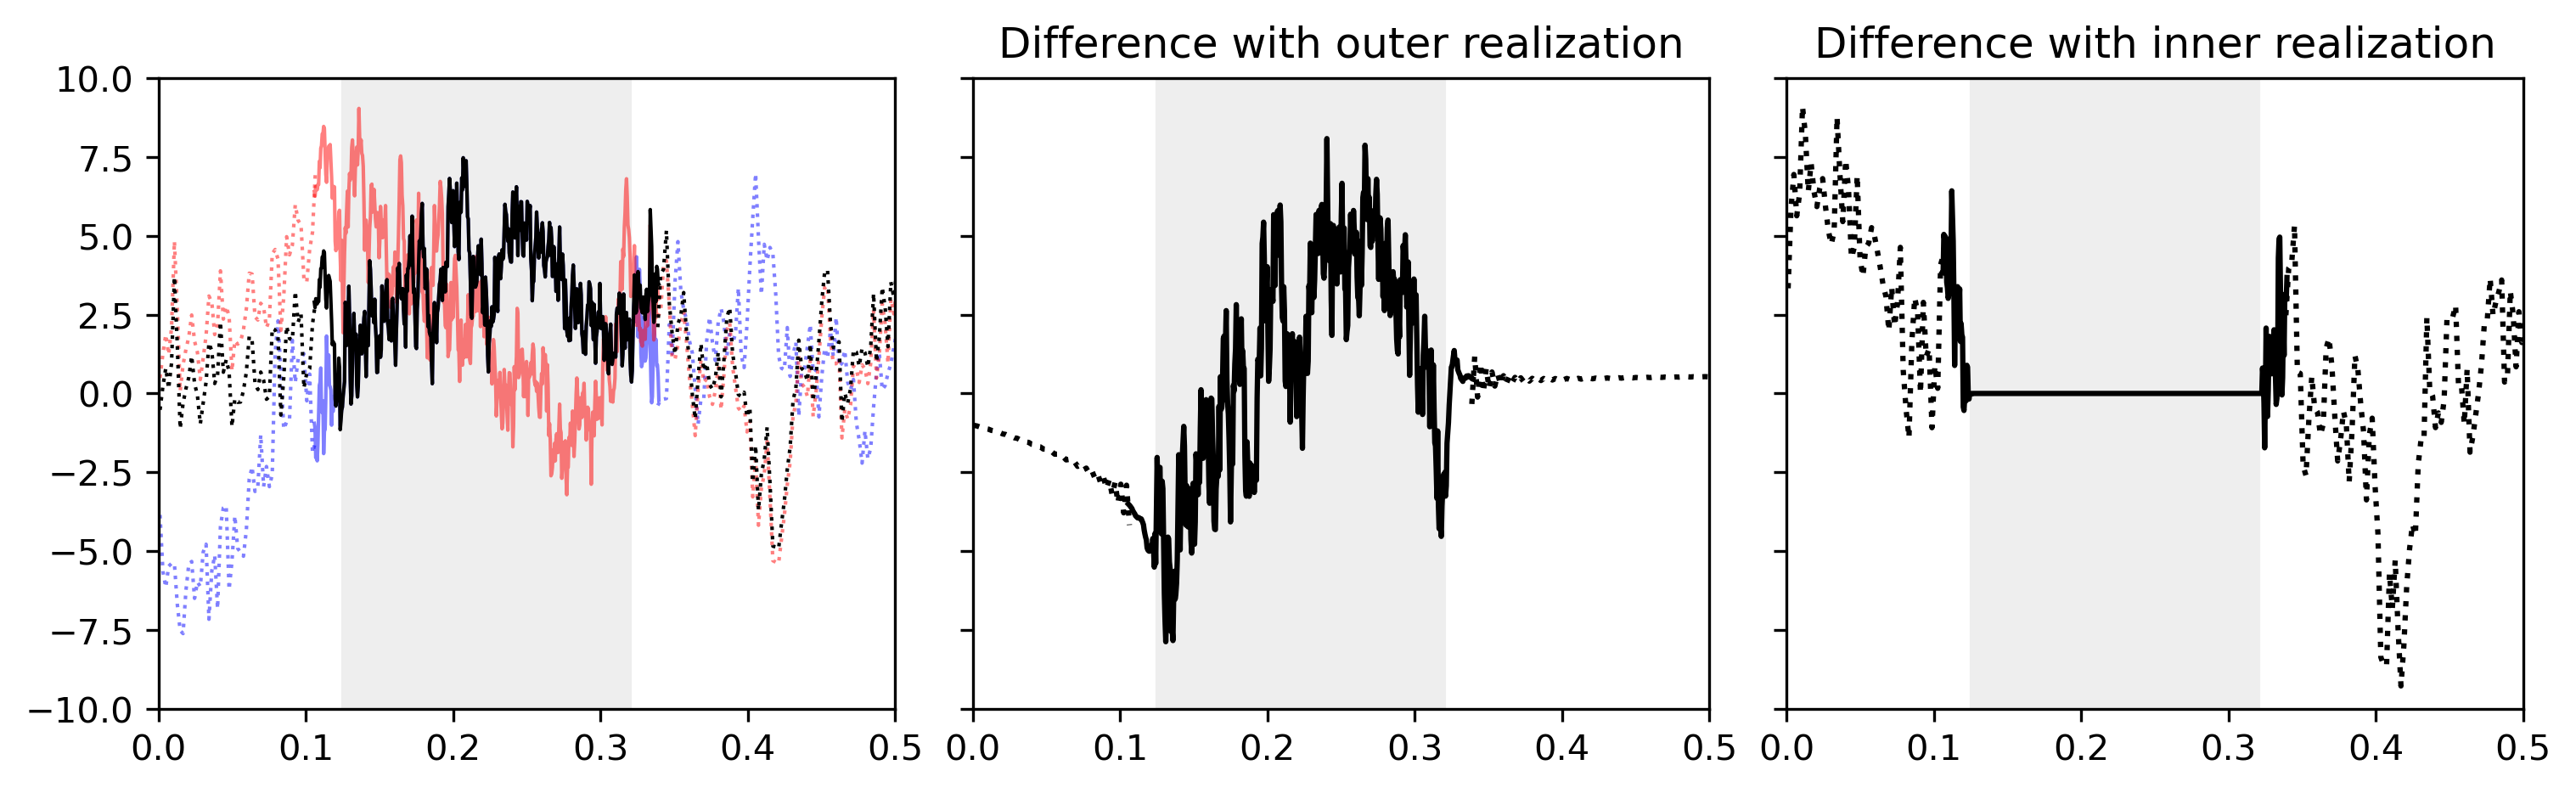

In [16]:
%autoreload 2
import constrainedzoom.plots
constrainedzoom.methods.use_filters=True
N = 512
splice_range = (256-200, 256+200)
offset = 50
fig, axes = p.subplots(ncols=3, figsize=(10, 3), sharex=True, sharey=True, constrained_layout=True)
fig.sca(axes[0])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,plaw=-1.5,plot_kwargs={'alpha':0.5, 'color':'b'}, linewidth=1, hires_window_offset=offset)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=2,plaw=-1.5,plot_kwargs={'alpha':0.5, 'color':'r'}, linewidth=1, hires_window_offset=offset)
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,splice_range=splice_range,plaw=-1.5,plot_kwargs={'color':'k'}, linewidth=1, hires_window_offset=offset)

fig.sca(axes[1])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,diff_seed=2,splice_range=splice_range,plaw=-1.5,plot_kwargs={'color':'k'}, hires_window_offset=offset)
p.title("Difference with outer realization")

fig.sca(axes[2])
constrainedzoom.plots.zoom_demo(nP=N,nW=N,seed=1,splice_seed=2,diff_seed=1,splice_range=splice_range,plaw=-1.5, plot_kwargs={"color": "k"}, hires_window_offset=offset)
p.xlim(0., 0.5)
p.ylim(-10,10)
p.title("Difference with inner realization")

As can be seen above, the filtering leads to some oscillations outside the edge of the zoomed region. When splicing a region, 
in to the toy implementation; otherwise this oscillation would be inside the mask region rather than just outside it.